In [1]:
# Clear all existing variables
%reset -f

In [2]:
#packages
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Widening the screen
from matplotlib import rcParams
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# Widening the screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
FS=25
rcParams['figure.dpi'] = 1800
rcParams['savefig.dpi'] = 800
rcParams['font.size'] = FS
rcParams['font.family'] = 'StixGeneral'
rcParams["mathtext.fontset"] = 'stix'
# rcParams["mathtext.default"] = "rm" 
# rcParams['xtick.direction'] = 'in'
plt.rc('font', size=FS)          # controls default text sizes
plt.rc('axes', titlesize=FS)     # fontsize of the axes title
plt.rc('axes', labelsize=FS)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=FS)    # fontsize of the tick labels
plt.rc('ytick', labelsize=FS)    # fontsize of the tick labels
plt.rc('legend', fontsize=FS)    # legend fontsize
plt.rc('figure', titlesize=FS)   # fontsize of the figure title

In [4]:
#grid
LX =435
LT =31#1990-2020
dx =1.0
dt =0.001

In [5]:
#parameter
#Ph: N1
D1  =50.0
A11 =1.0
A21 =0.917
A31 =0.962

#Su: N2
D2  =15.0
A12 =1.0
A22 =1.0
A32 =1.0

#Sp: N3
D3  =80.0
A13 =1.0
A23 =0.984
A33 =1.0

R1  =np.zeros(LX)+1.0
R2  =np.zeros(LX)+1.0
R3  =np.zeros(LX)+1.0
R1[0:180] =R1[0:180]-np.linspace(1,0,180)
R2[0:180] =R2[0:180]-np.linspace(1,0,180)
R3[0:50]  =R3[0:50] -1.0

In [6]:
#import data
import pandas
# area
df = pandas.read_csv('./Data S1 Percent cover.csv',header=0)
df1990   = df[df.Year == 1990]
df1990ph = df1990[df1990.Vegetation == 'ph']#
df1990su = df1990[df1990.Vegetation == 'su']
df1990sp = df1990[df1990.Vegetation == 'sp']

In [7]:
# salinity
dfe = pandas.read_csv('./Data S2 Salinity.csv',header=0)

In [8]:
# Salinity Before 1990
from numpy import polyfit, poly1d
dfe1990   = dfe[dfe['Year']<1990]
x1990     = dfe1990.Distance 
y1990     = dfe1990.Salinity
# polyfit
coeff1990 = polyfit(x1990, y1990, 1)
print(coeff1990)
# predict
f1990     = poly1d(coeff1990)
xnew1990  = np.linspace(0.0, (435.0-1.0)*30.0/1000.0,LX)
ynew1990  = f1990(xnew1990)

[0.02630668 0.62144737]


In [9]:
#initial value
N0 = 1.0
N1 = np.flipud( df1990ph.Percent_cover ) #Phragmites australis
N2 = np.flipud( df1990su.Percent_cover ) #Suaeda salsa
N3 = np.flipud( df1990sp.Percent_cover ) #Spartina alterniflora 

Ma = np.zeros((LT,LX))
Mb = np.zeros((LT,LX))
Mc = np.zeros((LT,LX))
Me = np.zeros((LT,LX))

In [10]:
#diffuse
def d2_dx2(Z): 
    Zleft = np.roll(Z, 1, axis=0)
    Zright = np.roll(Z, -1, axis=0)
    return (Zleft + Zright - 2.0 * Z) / dx**2

In [11]:
def d_dx(Z): # First order derivative that assumes periodic boundary conditions
    Zleft = np.roll(Z, 1, axis=0)
    Zcenter = Z[:]
    return (Zcenter - Zleft) / dx

# simulation

In [12]:
npoint = 10
npointE = 2
AA = np.linspace(4.0,4.0,1)#a=5.0 
BB = np.linspace(0.7927001132494514, 0.7927001132494514,1)#b=0.7927001132494514
c  = np.flipud(ynew1990)
DD = np.linspace(0.1, 0.1,1)#d=0.027887927684526
EE = np.linspace(0.0,0.18,npointE)#e=0.15 0.01,0.25
FF = np.linspace(0.01, 0.06,npoint)#c=0.1 0.05,0.15

PhMean = np.zeros((npointE,npoint))
SuMean = np.zeros((npointE,npoint))
SpMean = np.zeros((npointE,npoint))

In [13]:
SuiB = 0
for a in AA:
    for b in BB:
        for f in FF:
            for d in DD:
                SuiE = 0
                for e in EE:
                #main simulation
                    N1     = np.flipud( df1990ph.Percent_cover )
                    N2     = np.flipud( df1990su.Percent_cover )
                    N3     = np.flipud( df1990sp.Percent_cover )
                    
                    E      = np.flipud(ynew1990)
                    Ma     =np.zeros((LT,LX))
                    Mb     =np.zeros((LT,LX))
                    Mc     =np.zeros((LT,LX))
                    Me     =np.zeros((LT,LX))
                    for j in range(int(LT)):
                        Ma[j,:] = N1
                        Mb[j,:] = N2
                        Mc[j,:] = N3
                        Me[j,:] = E
                        for i in range(int(1/dt)):
                            a12 = (A12-a*(E-b))
                            a12[a12<=0.0] = 0.0 
                            N1, N2, N3,E = \
                            N1 + dt*( D1*d2_dx2(N1) + N1*(R1-A11*N1-A21*N2-A31*N3) ),\
                            N2 + dt*( D2*d2_dx2(N2) + N2*(R2-a12*N1-A22*N2-A32*N3) ),\
                            N3 + dt*( D3*d2_dx2(N3) + N3*(R3-A13*N1-A23*N2-A33*N3) + 5.5*d_dx(N3) ),\
                            E  + dt*( f*(c - E) + d*N3/(1.0+N3)*E - e*np.sum(N3)/LX*E )

                            #boundary conditions
                            N1[0]=N1[1]
                            N1[LX-1]=N1[LX-2]
                            N2[0]=N2[0]
                            N2[LX-1]=N2[LX-2]
                            N3[0]=N3[1]
                            N3[LX-1]=N3[LX-2]
                            E[LX-1]=E[LX-2]
                    PhMean[SuiE,SuiB] = np.mean(N1)
                    SuMean[SuiE,SuiB] = np.mean(N2)
                    SpMean[SuiE,SuiB] = np.mean(N3)
                    SuiE = SuiE+1
                SuiB = SuiB+1
        print(SuiE,SuiB,SuMean)

2 10 [[0.18213037 0.18194059 0.18175542 0.18157446 0.18139769 0.18122519
  0.18105684 0.18089234 0.18073179 0.18057522]
 [0.01311044 0.01427519 0.01550356 0.01679323 0.01814136 0.01954468
  0.02099954 0.02250194 0.0240476  0.02563203]]


# save to csv

In [14]:
# np.save('ParsAnalysis_F_FF.npy',FF)
# np.save('ParsAnalysis_F_PhMean.npy',PhMean)
# np.save('ParsAnalysis_F_SuMean.npy',SuMean)
# np.save('ParsAnalysis_F_SpMean.npy',SpMean)

In [15]:
# FF=np.load('ParsAnalysis_F_FF.npy')
# PhMean=np.load('ParsAnalysis_F_PhMean.npy')
# SuMean=np.load('ParsAnalysis_F_SuMean.npy')
# SpMean=np.load('ParsAnalysis_F_SpMean.npy')

# Plot

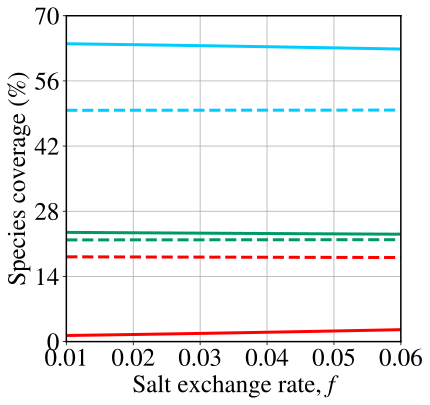

In [16]:
nticker = 6
from matplotlib import ticker
fig1, ax = plt.subplots(1, 1, figsize=(6, 6))
# line10, = ax.plot(FF, PhMean[0,:]*100, lw=2, color='b', label='P. a. (e=0.0)'); 
# line20, = ax.plot(FF, PhMean[1,:]*100, lw=2, color='b', linestyle='--', label='P. a. (e=0.07)'); 
# line11, = ax.plot(FF, SuMean[0,:]*100, lw=2, color='r', label='S. s. (e=0.0)'); 
# line21, = ax.plot(FF, SuMean[1,:]*100, lw=2, color='r', linestyle='--', label='S. s. (e=0.07)'); 
# line12, = ax.plot(FF, SpMean[0,:]*100, lw=2, color='g', label='S. a. (e=0.0)'); 
# line22, = ax.plot(FF, SpMean[1,:]*100, lw=2, color='g', linestyle='--', label='S. a. (e=0.07)');
line10, = ax.plot(FF, PhMean[0,:]*100, lw=3, color='#00CCFF', linestyle='--', label='P. a. (e=0.0)'); 
line20, = ax.plot(FF, PhMean[1,:]*100, lw=3, color='#00CCFF', label='P. a. (e=0.07)'); 
line11, = ax.plot(FF, SuMean[0,:]*100, lw=3, color='r', linestyle='--', label='S. s. (e=0.0)'); 
line21, = ax.plot(FF, SuMean[1,:]*100, lw=3, color='r', label='S. s. (e=0.07)'); 
line12, = ax.plot(FF, SpMean[0,:]*100, lw=3, color='#009966', linestyle='--', label='S. a. (e=0.0)'); 
line22, = ax.plot(FF, SpMean[1,:]*100, lw=3, color='#009966', label='S. a. (e=0.07)');

ax.set_xlim(0.01, 0.06)
ax.set_xticks(np.linspace(0.01, 0.06,nticker))

ax.set_ylim(0.0, 70)
# Ylabels = np.linspace(0.0, 0.7,nticker).round(1)
ax.set_yticks(np.linspace(0.0, 70,nticker))

ax.set_xlabel('Salt exchange rate, $f$');
ax.set_ylabel('Species coverage (%)');

ax.spines['bottom'].set_linewidth(1.5);
ax.spines['left'].set_linewidth(1.5);
ax.spines['right'].set_linewidth(1.5);
ax.spines['top'].set_linewidth(1.5);

# ax.legend(fontsize=15,frameon=False)
ax.grid()
fig1.savefig('FIgure S5e Sensitivity analysisParF.pdf',bbox_inches='tight')

© 2021, Kang Zhang, ECNU. Follow Johan van de Koppel & Quan-Xing Liu.